# Age Estimation using the YOLO algorithm

Authors: Isak Killingrød, Jon A B Larssen, Jon I J Skånøy

About

## Setup

### Installation

In [1]:
# Run installation


# Server
#!python -m pip install --upgrade pip 
#!python -m pip install requests tqdm torch torchvision pandas matplotlib pillow numpy opencv-python ipywidgets

In [2]:
%matplotlib inline
from tqdm.notebook import tqdm

### Global variables

In [3]:
USERNAME = 'adiencedb'
PASSWORD = 'adience'

In [4]:
DATA_DIR = 'data'

In [5]:
BASE_URL = 'http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/'

ARCHIVE_URL = BASE_URL + "faces.tar.gz"

CASCADE_FILENAME = "haarcascade_frontalface_default.xml"
CASCADE_URL = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'

In [6]:
AGE_CATEGORIES = [
    (0, 2), (4, 6), (8, 12), (15, 20), (25, 32), 
    (38, 43), 
    (48, 53), (60, 100)
]

### Imports

In [7]:
import os
import shutil
import requests
import tarfile
from tqdm.notebook import tqdm
from requests.auth import HTTPBasicAuth
import torch
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import re
import cv2
from concurrent.futures import ThreadPoolExecutor
from glob import glob
from pathlib import Path
import yaml
import json
from datetime import datetime
import optuna
from optuna.trial import TrialState
from ultralytics import YOLO
import platform

### Config

In [8]:
if platform.system() == "Windows":
    print("Running on Windows")
    STORAGE = 'YOLO_NB_LOCAL'
    MODEL_SIZES = ['n', 's', 'm', 'l','x']
    MODEL_VERSIONS = [8,9,10,11,12]
    IMAGE_SIZES = [320,416,640]
elif platform.system() == "Linux":
    print("Running on Linux")
    STORAGE = 'YOLO_NB_SERVER'
    MODEL_SIZES = ['x', 'l', 'm', 's', 'n']
    MODEL_VERSIONS = [12,11,10,9,8]
    IMAGE_SIZES = [640,416,320]
else:
    print(f"Running on {platform.system()}")
    STORAGE = 'YOLO_NB_UNKNOWN'

Running on Linux


In [9]:
# DO_TRAIN

In [10]:
NUM_WORKERS = os.cpu_count() // 2 # For preprocessing, not tuning or training

In [11]:
ARCHIVE_PATH = os.path.join(DATA_DIR, "faces.tar.gz")

In [12]:
CASCADE_DIR = os.path.join(DATA_DIR, "haarcascades")
os.makedirs(CASCADE_DIR, exist_ok=True)
CASCADE_PATH = os.path.join(CASCADE_DIR, CASCADE_FILENAME)

### Functions

In [13]:
def show_sample_with_bbox(img_path, label_path):
    """Display an image with its bounding box"""
    # Load image
    img = Image.open(img_path)
    img_w, img_h = img.size
    
    # Load label
    with open(label_path, 'r') as f:
        line = f.readline().strip().split()
        class_id = int(line[0])
        x_center, y_center, width, height = map(float, line[1:5])
    
    # Convert YOLO format to pixel coordinates
    x1 = int((x_center - width/2) * img_w)
    y1 = int((y_center - height/2) * img_h)
    x2 = int((x_center + width/2) * img_w)
    y2 = int((y_center + height/2) * img_h)
    
    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(np.array(img))
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
    
    # Label with age category
    age_category = creator.age_categories[class_id]
    plt.title(f"Age Category: {age_category[0]}-{age_category[1]} years")
    plt.axis('off')
    plt.show()

In [14]:
def get_model_filename(version, size):
    """
    Returns the correct YOLO model filename based on version and size.
    Only supports detection models.

    Args:
        version (int or str): YOLO version (8–12)
        size (str): Model size, depends on version

    Returns:
        str: Filename of the model checkpoint, e.g. 'yolov9e.pt'

    Raises:
        ValueError: If version or size is unsupported
    """
    version = str(version).lower()
    size = size.lower()

    if version == '9':
        model_map = {
            'n': 'yolov9t.pt',
            's': 'yolov9s.pt',
            'm': 'yolov9m.pt',
            'l': 'yolov9c.pt',
            'x': 'yolov9e.pt',
        }
        return model_map[size]

    if version in ['8', '10']:
        return f'yolov{version}{size}.pt'
    elif version in ['11', '12']:
        return f'yolo{version}{size}.pt'


In [15]:
def get_all_data_yaml_paths(base_dir):
    return sorted([
        str(p) for p in Path(base_dir).rglob("data.yaml")
        if "size_" in str(p)
    ])


In [16]:
def run_all_datasets_optuna_and_training(
    base_dataset_dir='data/age_dataset',
    model_sizes=['n', 's', 'm', 'l', 'x'],
    model_versions=[8, 9, 10, 11, 12],
    image_sizes=[320, 416, 640],
    n_trials=10,
    epochs_per_trial=40,
    final_epochs=100,
    device='0',
    output_base='runs/age_exp'
):
    """
    Grid search over datasets, model versions, and model sizes with Optuna tuning.

    Args:
        base_dataset_dir: Root dir with YOLO-style datasets (per image size)
        model_sizes: List of model sizes per version (e.g., ['n', 's', ...])
        model_versions: List of YOLO model versions (e.g., [8, 9, 10, ...])
        image_sizes: List of dataset image sizes to include (e.g., [320, 416, 640])
        n_trials: Optuna trials per combination
        epochs_per_trial: Epochs during Optuna tuning
        final_epochs: Final training epochs
        device: Device to use (e.g., '0', 'cpu')
        output_base: Output directory base
        run_final_training: If True, run final training after tuning
    """

    for imgsz in image_sizes:
        data_yaml = os.path.join(base_dataset_dir, f"size_{imgsz}", "data.yaml")

        if not os.path.exists(data_yaml):
            print(f"⚠️  Skipping missing dataset: {data_yaml}")
            continue

        print(f"\n📂 Evaluating dataset: {data_yaml}")

        for version in model_versions:
            for size in model_sizes:
                try:
                    model_filename = get_model_filename(version, size)
                except ValueError as e:
                    print(f"⏭️ Skipping unsupported model: YOLOv{version}-{size} ({e})")
                    continue

                dataset_name = Path(data_yaml).parent.name
                run_name = f"v{version}_{size}_{imgsz}"
                output_dir = os.path.join(output_base, run_name)

                print(f"\n{'='*100}")
                print(f"🧪 Tuning: YOLOv{version}-{size} on dataset {dataset_name} ({imgsz}px)")
                print(f"{'='*100}")

                best_params, best_value = run_optuna_tuning(
                    data_yaml=data_yaml,
                    model_size=size,
                    model_version=version,
                    output_dir=output_dir,
                    n_trials=n_trials,
                    epochs_per_trial=epochs_per_trial,
                    device=device
                )


In [17]:
def make_objective(model_path, data_yaml, imgsz, device, epochs_per_trial):
    def objective(trial):
        params = {
            'lr0': trial.suggest_float('lr0', 1e-5, 1e-2, log=True),
            'lrf': trial.suggest_float('lrf', 0.01, 0.2),
            'momentum': trial.suggest_float('momentum', 0.8, 0.95),
            'weight_decay': trial.suggest_float('weight_decay', 1e-4, 1e-3, log=True),
            'warmup_epochs': trial.suggest_int('warmup_epochs', 1, 5),
            'warmup_momentum': trial.suggest_float('warmup_momentum', 0.5, 0.95),
            'box': trial.suggest_float('box', 0.0, 8.0),
            'cls': trial.suggest_float('cls', 0.0, 1.0),
            'hsv_h': trial.suggest_float('hsv_h', 0.0, 1.0),
            'hsv_s': trial.suggest_float('hsv_s', 0.0, 1.0),
            'hsv_v': trial.suggest_float('hsv_v', 0.0, 1.0),
            'degrees': trial.suggest_float('degrees', 0.0, 180.0),
            'translate': trial.suggest_float('translate', 0.0, 1.0),
            'scale': trial.suggest_float('scale', 0.0, 1.0),
            'flipud': trial.suggest_float('flipud', 0.0, 1.0),
            'fliplr': trial.suggest_float('fliplr', 0.0, 1.0),
            'bgr': trial.suggest_float('bgr', 0.0, 1.0),
            'mixup': trial.suggest_float('mixup', 0.0, 1.0),
            'batch': trial.suggest_categorical('batch', [8, 16, 32]),
            'imgsz': imgsz,
            'optimizer': 'AdamW'
        }

        try:
            model = YOLO(model_path)
            results = model.train(
                data=data_yaml,
                cache='disk',
                workers=1,
                epochs=epochs_per_trial,
                device=device,
                verbose=False,
                plots=True,
                **params
            )
            return float(results.fitness) if hasattr(results, 'fitness') else 0.0
        except Exception as e:
            print(f"❌ Trial failed with error: {e}")
            return 0.0
    return objective


In [18]:
def run_optuna_tuning(
    data_yaml,
    model_size='n',
    output_dir='runs/tune_optuna',
    n_trials=40,
    epochs_per_trial=50,
    model_version=8,
    device='0'
):
    import warnings
    from optuna.trial import TrialState
    warnings.filterwarnings("ignore", category=UserWarning)

    with open(data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)

    dataset_dir = os.path.dirname(os.path.abspath(data_yaml))
    size_match = re.search(r"size_(\d+)", dataset_dir)
    imgsz = int(size_match.group(1)) if size_match else 416

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    run_name = f"optuna_v{model_version}_{model_size}_{imgsz}_{timestamp}"
    output_path = os.path.join(output_dir, run_name)
    os.makedirs(output_path, exist_ok=True)

    try:
        model_path = get_model_filename(model_version, model_size)
    except ValueError as e:
        print(f"❌ Invalid model request: {e}")
        return {}, 0.0

    study_name = f"yolo_v{model_version}{model_size}_img{imgsz}"
    study_storage = f"sqlite:///{STORAGE}.db"

    # 📍 Query the database manually without creating a study
    optuna_study_summaries = optuna.study.get_all_study_summaries(storage=study_storage)
    existing_study = None
    for s in optuna_study_summaries:
        if s.study_name == study_name:
            existing_study = s
            break

    if existing_study:
        existing_trials = existing_study.n_trials
    else:
        existing_trials = 0


    if existing_trials >= n_trials:
        print(f"⏩ Skipping tuning: {existing_trials} completed trials already (target was {n_trials}).")
        if existing_study:
            study = optuna.load_study(study_name=study_name, storage=study_storage)
            best_params = study.best_params
            best_value = study.best_value
        else:
            best_params = {}
            best_value = 0.0
    else:
        remaining_trials = n_trials - existing_trials
        print(f"🔄 Starting/resuming tuning: {remaining_trials} trials needed.")
        study = optuna.create_study(
            direction='maximize',
            study_name=study_name,
            storage=study_storage,
            load_if_exists=True
        )

        objective = make_objective(model_path, data_yaml, imgsz, device, epochs_per_trial)
        study.optimize(objective, n_trials=remaining_trials)

        best_params = study.best_params
        best_value = study.best_value

    with open(os.path.join(output_path, f'best_params_v{model_version}_{model_size}.json'), 'w') as f:
        json.dump(best_params, f, indent=4)

    print(f"\n✅ Best result for YOLOv{model_version}-{model_size} ({imgsz}px): {best_value:.4f}")
    return best_params, best_value


In [19]:
def find_max_batch_size(model_path, imgsz, device='cuda:0', min_batch=8, max_batch=512):
    try:
        model = YOLO(model_path)
        model.model = model.model.to(device)
    except Exception as e:
        print(f"❌ Could not load model {model_path}: {e}")
        return None

    batch = max_batch
    while batch >= min_batch:
        try:
            dummy = torch.zeros((batch, 3, imgsz, imgsz)).to(device)
            with torch.no_grad():
                _ = model.model(dummy)
            return batch  
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                torch.cuda.empty_cache()
                batch //= 2
            else:
                print(f"❌ Runtime error (non-OOM) for {model_path}: {e}")
                return None
        except Exception as e:
            print(f"❌ Other error for {model_path}: {e}")
            return None
    return None

### Classes

In [20]:
class FaceAgeDatasetCreator:
    def __init__(
        self,
        base_dir="data",
        faces_archive=None,
        faces_dir=None,
        output_dir=None,
        cascade_dir=None,
        fold_files=None,
        img_size=416,
        max_workers=4
    ):
        self.base_dir = base_dir
        os.makedirs(self.base_dir, exist_ok=True)
        
        self.faces_archive = faces_archive or os.path.join(base_dir, "faces.tar.gz")
        self.faces_dir = faces_dir or os.path.join(base_dir, "faces")
        self.output_dir = output_dir or os.path.join(base_dir, "age_dataset")
        self.cascade_dir = cascade_dir or os.path.join(base_dir, "haarcascades")

        os.makedirs(self.output_dir, exist_ok=True)
        os.makedirs(self.cascade_dir, exist_ok=True)

        if fold_files is None:
            self.fold_files = [
                os.path.join(base_dir, f"fold_{i}_data.txt") for i in range(5)
            ]
        else:
            self.fold_files = fold_files

        self.img_sizes = img_size if isinstance(img_size, list) else [img_size]
        self.img_size = self.img_sizes[0]

        self.age_categories = [
            (0, 2), (4, 6), (8, 12), (15, 20), (25, 32),
            (38, 43), (48, 53), (60, 100)
        ]

        self.max_workers = max_workers or (os.cpu_count() // 2)

        try:
            self.opencv_available = True
            self.face_cascade = self.load_cascade()
        except ImportError:
            self.opencv_available = False
            self.face_cascade = None
            print("OpenCV not available. Face detection disabled.")

    def load_cascade(self):
        paths = [
            # cv2.data.haarcascades + 'haarcascade_frontalface_default.xml',
            os.path.join(self.cascade_dir, 'haarcascade_frontalface_default.xml'),
            'haarcascade_frontalface_default.xml'
        ]
        for path in paths:
            if os.path.exists(path):
                cascade = cv2.CascadeClassifier(path)
                if cascade.empty():
                    print(f"Warning: Failed to load cascade from {path}")
                else:
                    return cascade
        print("Cascade not found or failed to load.")
        return None

    def extract_faces_archive(self):
        if not os.path.exists(self.faces_dir):
            os.makedirs(self.faces_dir, exist_ok=True)
            print(f"Extracting {self.faces_archive} to {self.faces_dir}...")
            with tarfile.open(self.faces_archive, 'r:gz') as tar:
                for member in tqdm(tar.getmembers(), desc="Extracting faces"):
                    if member.name.startswith("faces/"):
                        member.name = member.name[len("faces/"):]
                        if member.name:
                            tar.extract(member, self.faces_dir, filter='data')
            print("Extraction complete.")
        else:
            print(f"{self.faces_dir} already exists. Skipping extraction.")

    def get_age_class(self, age_info):
        try:
            if isinstance(age_info, str) and '(' in age_info:
                match = re.findall(r'\d+', age_info)
                if len(match) >= 2:
                    lower, upper = int(match[0]), int(match[1])
                    for i, cat in enumerate(self.age_categories):
                        if (lower, upper) == cat:
                            return i
            else:
                age = int(age_info)
                for i, (low, high) in enumerate(self.age_categories):
                    if low <= age <= high:
                        return i
            return -1
        except:
            return -1

    def load_fold_data(self, fold_files=None):
        if fold_files is None:
            fold_files = self.fold_files
        all_data = []
        column_names = [
            'user_id', 'original_image', 'face_id', 'age', 'gender', 
            'x', 'y', 'dx', 'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score'
        ]
        for fold_file in fold_files:
            try:
                df = pd.read_csv(fold_file, sep='\t', header=None, names=column_names)
                df['age_class'] = df['age'].apply(self.get_age_class)
                df = df[df['age_class'] != -1]
                all_data.append(df)
            except Exception as e:
                print(f"Error loading {fold_file}: {e}")
        return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame(columns=column_names + ['age_class'])

    def get_image_path(self, row):
        filename = f"coarse_tilt_aligned_face.{row['face_id']}.{row['original_image']}"
        return os.path.join(self.faces_dir, str(row['user_id']), filename)

    def detect_face(self, image_np):
        if not self.opencv_available:
            return None
    
        try:
            cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            if cascade.empty():
                print("Failed to load cascade.")
                return None
            gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
            faces = cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
            return max(faces, key=lambda r: r[2] * r[3]) if len(faces) > 0 else None
        except Exception as e:
            print(f"Face detection failed: {e}")
            return None

    def is_dataset_complete(self, size_dir):
        """
        Check if the dataset for a given image size is complete and ready.
        """
        expected = [
            os.path.join(size_dir, "data.yaml"),
            os.path.join(size_dir, "classes.txt"),
            os.path.join(size_dir, "images/train"),
            os.path.join(size_dir, "images/val"),
            os.path.join(size_dir, "labels/train"),
            os.path.join(size_dir, "labels/val"),
        ]
        for path in expected:
            if not os.path.exists(path):
                return False
        
        val_imgs = list(Path(size_dir).joinpath("images/val").glob("*.jpg"))
        val_lbls = list(Path(size_dir).joinpath("labels/val").glob("*.txt"))
        
        return len(val_imgs) > 0 and len(val_imgs) == len(val_lbls)

    def process_dataset(self, data, img_dir, label_dir):
        os.makedirs(img_dir, exist_ok=True)
        os.makedirs(label_dir, exist_ok=True)

        transform = transforms.Resize((self.img_size, self.img_size))

        def process_row(idx_row):
            idx, row = idx_row
            try:
                img_path = self.get_image_path(row)
                if not os.path.exists(img_path):
                    return
        
                with Image.open(img_path).convert('RGB') as img:
                    orig_width, orig_height = img.size
                    img_resized = transform(img)
        
                    img_np = np.array(img)
                    img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
                    face_coords = self.detect_face(img_cv)
        
                    filename = os.path.basename(img_path).replace('coarse_tilt_aligned_face.', '')
                    base_filename = f"{idx}_{filename.split('.')[0]}"
                    save_path = os.path.join(img_dir, f"{base_filename}.jpg")
                    img_resized.save(save_path)
        
                    # Handle YOLO box
                    if face_coords is not None and isinstance(face_coords, (tuple, list, np.ndarray)):
                        x, y, w, h = face_coords
                        x_center = (x + w / 2) / orig_width
                        y_center = (y + h / 2) / orig_height
                        width_norm = w / orig_width
                        height_norm = h / orig_height
                    else:
                        x_center, y_center = 0.5, 0.5
                        width_norm, height_norm = 0.8, 0.8
        
                    # Clamp
                    x_center = max(0, min(1, x_center))
                    y_center = max(0, min(1, y_center))
                    width_norm = max(0.05, min(1, width_norm))
                    height_norm = max(0.05, min(1, height_norm))
        
                    class_id = int(row['age_class'])
                    if not (0 <= class_id < len(self.age_categories)):
                        print(f"Invalid age class at index {idx}: {class_id}")
                        return
        
                    label_path = os.path.join(label_dir, f"{base_filename}.txt")
                    with open(label_path, 'w') as f:
                        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")
        
            except Exception as e:
                print(f"Error at index {idx}: {e}")


        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            list(tqdm(executor.map(process_row, data.iterrows()), total=len(data)))

    def create_data_yaml_for_size(self, output_dir):
        yaml_path = os.path.join(output_dir, 'data.yaml')
        with open(yaml_path, 'w') as f:
            train_dir = os.path.abspath(os.path.join(output_dir, "images/train"))
            val_dir = os.path.abspath(os.path.join(output_dir, "images/val"))
            f.write(f"train: {train_dir}\n")
            f.write(f"val: {val_dir}\n")
            f.write(f"nc: {len(self.age_categories)}\n")
            f.write("names:\n")
            classes_path = os.path.join(output_dir, 'classes.txt')
            with open(classes_path, 'r') as cf:
                for i, line in enumerate(cf):
                    f.write(f"  {i}: '{line.strip()}'\n")

    def create_yolo_dataset(self, train_folds=[0, 1, 2, 3], val_fold=4, specific_sizes=None):
        sizes_to_process = specific_sizes if specific_sizes else self.img_sizes
        for img_size in sizes_to_process:
            size_dir = os.path.join(self.output_dir, f"size_{img_size}")
    
            if not self.is_dataset_complete(size_dir):
                print(f"\n=== Processing for image size {img_size}x{img_size} ===")
                self.img_size = img_size
                img_train, img_val = os.path.join(size_dir, 'images/train'), os.path.join(size_dir, 'images/val')
                lbl_train, lbl_val = os.path.join(size_dir, 'labels/train'), os.path.join(size_dir, 'labels/val')
                for d in [img_train, img_val, lbl_train, lbl_val]:
                    os.makedirs(d, exist_ok=True)
    
                with open(os.path.join(size_dir, 'classes.txt'), 'w') as f:
                    for (low, high) in self.age_categories:
                        f.write(f"age_{low}_{high}\n")
    
                train_data = self.load_fold_data([self.fold_files[i] for i in train_folds])
                val_data = self.load_fold_data([self.fold_files[val_fold]])
    
                print(f"Train images: {len(train_data)}, Val images: {len(val_data)}")
    
                self.process_dataset(train_data, img_train, lbl_train)
                self.process_dataset(val_data, img_val, lbl_val)
                self.create_data_yaml_for_size(size_dir)
                print(f"✅ Dataset ready at: {size_dir}")
            else:
                print(f"✅ {size_dir} already complete. Skipping...")


## Download data

### Session

In [21]:
session = requests.Session()
session.headers.update({
    "User-Agent": "Mozilla/5.0",
    "Referer": BASE_URL
})

### Folds

In [22]:
fold_files = [f"fold_{i}_data.txt" for i in range(5)]

for fname in fold_files:
    url = BASE_URL + fname
    dest = os.path.join(DATA_DIR, fname)
    
    if os.path.exists(dest):
        print(f"{dest} already exist")
        continue

    print(f"Downloading {url}")
    
    response = session.get(url, auth=HTTPBasicAuth(USERNAME, PASSWORD))
    
    if response.status_code == 200:
        with open(dest, 'wb') as f:
            f.write(response.content)
        print(f"Saved: {dest}")
    else:
        print(f"Failed: {url} (Status: {response.status_code})")

data/fold_0_data.txt already exist
data/fold_1_data.txt already exist
data/fold_2_data.txt already exist
data/fold_3_data.txt already exist
data/fold_4_data.txt already exist


### Faces

In [23]:
if not os.path.exists(ARCHIVE_PATH):
    print(f"\nDownloading archive: {ARCHIVE_URL}")
    response = session.get(ARCHIVE_URL, auth=HTTPBasicAuth(USERNAME, PASSWORD), stream=True)

    if response.status_code == 200:
        total_size = int(response.headers.get('content-length', 0))
        chunk_size = 8192

        with open(ARCHIVE_PATH, 'wb') as f, tqdm(
            desc="Downloading faces.tar.gz",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    bar.update(len(chunk))
        
        print(f"Downloaded: {ARCHIVE_PATH}")
    else:
        print(f"Failed to download archive (Status: {response.status_code})")
else:
    print(f"{ARCHIVE_PATH} already exist")

data/faces.tar.gz already exist


### Haar Cascade

In [24]:
if not os.path.exists(CASCADE_PATH):
    print(f"\nDownloading Haar cascade: {CASCADE_FILENAME}")
    try:
        response = requests.get(CASCADE_URL, stream=True)
        if response.status_code == 200:
            with open(CASCADE_PATH, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Downloaded cascade file to: {CASCADE_PATH}")
        else:
            print(f"Failed to download cascade file (Status: {response.status_code})")
    except Exception as e:
        print(f"Error downloading cascade file: {e}")
else:
    print(f"Cascade file already exists: {CASCADE_PATH}")

Cascade file already exists: data/haarcascades/haarcascade_frontalface_default.xml


## Preprocess data

In [25]:
creator = FaceAgeDatasetCreator(
    base_dir=DATA_DIR,
    img_size=[640, 416, 320],
    max_workers=NUM_WORKERS
)

### Folds

In [26]:
fold_files = creator.fold_files
print(f"Looking for fold files: {fold_files}")

Looking for fold files: ['data/fold_0_data.txt', 'data/fold_1_data.txt', 'data/fold_2_data.txt', 'data/fold_3_data.txt', 'data/fold_4_data.txt']


In [27]:
data = creator.load_fold_data()
print(f"Loaded {len(data)} records from fold files")

Loaded 17411 records from fold files



Sample data:


,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,age_class
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17,4
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94,4
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74,4
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47,4
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34,4


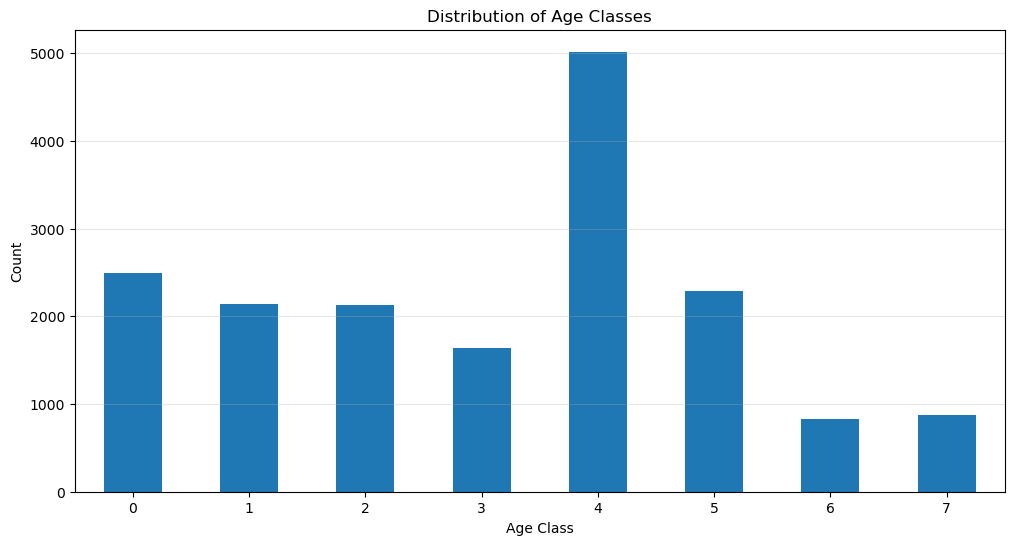

In [28]:
if len(data) > 0:
    print("\nSample data:")
    display(data.head())
    
    # Show age distribution
    plt.figure(figsize=(12, 6))
    data['age_class'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Age Classes')
    plt.xlabel('Age Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

### Extract faces

In [29]:
creator.extract_faces_archive()

data/faces already exists. Skipping extraction.


### Generate dataset

In [30]:
creator.create_yolo_dataset(train_folds=[0, 1, 2, 3], val_fold=4)

✅ data/age_dataset/size_640 already complete. Skipping...
✅ data/age_dataset/size_416 already complete. Skipping...
✅ data/age_dataset/size_320 already complete. Skipping...


## Hyperparameter tuning

In [ ]:
run_all_datasets_optuna_and_training(
    base_dataset_dir='data/age_dataset',
    model_sizes=MODEL_SIZES,
    model_versions=MODEL_VERSIONS, 
    image_sizes=IMAGE_SIZES,
    n_trials=5, # per combination
    epochs_per_trial=10,
    final_epochs=100,
    device='0',
    output_base='runs/age_exp'
)


📂 Evaluating dataset: data/age_dataset/size_320/data.yaml

🧪 Tuning: YOLOv8-n on dataset size_320 (320px)
⏩ Skipping tuning: 5 completed trials already (target was 5).

✅ Best result for YOLOv8-n (320px): 0.2749

🧪 Tuning: YOLOv8-s on dataset size_320 (320px)


[I 2025-04-27 11:16:48,834] A new study created in RDB with name: yolo_v8m_img320


⏩ Skipping tuning: 5 completed trials already (target was 5).

✅ Best result for YOLOv8-s (320px): 0.4071

🧪 Tuning: YOLOv8-m on dataset size_320 (320px)
🔄 Starting/resuming tuning: 5 trials needed.
New https://pypi.org/project/ultralytics/8.3.118 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.105 🚀 Python-3.10.17 torch-2.7.0+cu126 CUDA:0 (NVIDIA A100 80GB PCIe MIG 1g.20gb, 19968MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data/age_dataset/size_320/data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train40, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, ma